In [1]:
!pip install transformers[sentencepiece]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 97.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.1 MB/s eta 0:00:00


In [2]:
! pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 21.3 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [4]:
import pandas as pd
import numpy as np
import random
from datasets import Dataset
from transformers import BertModel, BertTokenizer
from transformers import AutoTokenizer, AutoModelForMaskedLM, \
 DataCollatorForLanguageModeling, Trainer, TrainingArguments
import torch
import tensorflow as tf
from tensorflow import keras
from transformers import BertModel, BertTokenizer
from keras.utils import plot_model

# Load Data

In [5]:
path='/content/drive/MyDrive/Extension1.xlsx'
df = pd.read_excel(path, header=None, names=['question', 'answer'])

In [6]:
candidate_answers = df['answer'].unique()

In [7]:
candidate_answers[0]

'پس \u200e\u200e\u200e\u200e\u200e\u200e\u200e\u200e\u200e\u200e\u200e\u200e\u200eاز انجام خرید سیم کارت از طریق فروشگاه آنلاین همراه اول، می توانید با شماره ای که با آن اقدام به خرید سیم کارت نموده اید وارد حساب کاربری خود شده و در بخش سفارشات من وضعیت خرید را بررسی نمایید.'

# Fine tune BERT model

In [8]:
sentences = list(df['answer']) + list(df['question'])
dataset = Dataset.from_dict({"text": sentences})

### Tokenizing

In [9]:
model_checkpoint = "HooshvareLab/bert-base-parsbert-uncased"
fine_tuned_checkpoint = f"model/{model_checkpoint}_ft"

In [10]:
tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
tokenized_dataset = dataset.map(lambda x: tokenizer(x["text"]), batched=True, num_proc=4, remove_columns=["text"])
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

#3:   0%|          | 0/1 [00:00<?, ?ba/s]

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#2:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
args = TrainingArguments(
    "test-clm",
    learning_rate=2e-5,
    weight_decay=0.01,
    save_total_limit=20,
    evaluation_strategy = "epoch",)
trainer = Trainer(
    model=model,
    args= args,
    train_dataset=tokenized_dataset,
    eval_dataset=tokenized_dataset,
    data_collator=data_collator,
)
# train
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2592
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 972
  Number of trainable parameters = 162942880


Epoch,Training Loss,Validation Loss
1,No log,0.577491
2,0.548200,0.503759
3,0.548200,0.401061


***** Running Evaluation *****
  Num examples = 2592
  Batch size = 8
Saving model checkpoint to test-clm/checkpoint-500
Configuration saved in test-clm/checkpoint-500/config.json
Configuration saved in test-clm/checkpoint-500/generation_config.json
Model weights saved in test-clm/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2592
  Batch size = 8
***** Running Evaluation *****
  Num examples = 2592
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=972, training_loss=0.40753097691163115, metrics={'train_runtime': 336.0433, 'train_samples_per_second': 23.14, 'train_steps_per_second': 2.892, 'total_flos': 372971429518848.0, 'train_loss': 0.40753097691163115, 'epoch': 3.0})

In [12]:
# save model + tokenizer
trainer.save_model(fine_tuned_checkpoint)
tokenizer.save_pretrained(fine_tuned_checkpoint)

Saving model checkpoint to model/HooshvareLab/bert-base-parsbert-uncased_ft
Configuration saved in model/HooshvareLab/bert-base-parsbert-uncased_ft/config.json
Configuration saved in model/HooshvareLab/bert-base-parsbert-uncased_ft/generation_config.json
Model weights saved in model/HooshvareLab/bert-base-parsbert-uncased_ft/pytorch_model.bin
tokenizer config file saved in model/HooshvareLab/bert-base-parsbert-uncased_ft/tokenizer_config.json
Special tokens file saved in model/HooshvareLab/bert-base-parsbert-uncased_ft/special_tokens_map.json


('model/HooshvareLab/bert-base-parsbert-uncased_ft/tokenizer_config.json',
 'model/HooshvareLab/bert-base-parsbert-uncased_ft/special_tokens_map.json',
 'model/HooshvareLab/bert-base-parsbert-uncased_ft/vocab.txt',
 'model/HooshvareLab/bert-base-parsbert-uncased_ft/added_tokens.json')

# Data Prepration

In [13]:
def Preprocess_For_Bert(text, tokenizer):
  marked_text = "[CLS] " + text + " [SEP]"
  tokenized_text = tokenizer.tokenize(marked_text)
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  segments_ids = [1]*len(indexed_tokens)
  # convert inputs to tensors
  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensor = torch.tensor([segments_ids])
  return tokenized_text, tokens_tensor, segments_tensor


def Etract_Bert_Embeds(tokens_tensor, segments_tensor, model):
  with torch.no_grad():
    # obtain hidden states
    outputs = model(tokens_tensor, segments_tensor)
    hidden_states = outputs[2]
  # concatenate the tensors for all layers
  # use "stack" to create new dimension in tensor
  token_embeddings = torch.stack(hidden_states, dim=0)
  # remove dimension 1, the "batches"
  token_embeddings = torch.squeeze(token_embeddings, dim=1)
  # swap dimensions 0 and 1 so we can loop over tokens
  token_embeddings = token_embeddings.permute(1,0,2)
  # intialized list to store embeddings
  token_vecs_sum = []
  # "token_embeddings" is a [Y x 12 x 768] tensor
  # where Y is the number of tokens in the sentence
  # loop over tokens in sentence
  for token in token_embeddings:
  # "token" is a [12 x 768] tensor
  # sum the vectors from the last four layers
    sum_vec = torch.sum(token[-4:], dim=0)
    token_vecs_sum.append(sum_vec)
  return token_vecs_sum

##### load saved models

In [14]:
bert_model = BertModel.from_pretrained(fine_tuned_checkpoint, output_hidden_states = True)
tokenizer = BertTokenizer.from_pretrained(fine_tuned_checkpoint)

loading configuration file model/HooshvareLab/bert-base-parsbert-uncased_ft/config.json
Model config BertConfig {
  "_name_or_path": "HooshvareLab/bert-base-parsbert-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.26.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 100000
}

loading weights file model/HooshvareLab/bert-base-parsbert-uncased_ft/pytorch_model.bin
Some weights of the model checkpoint at model/HooshvareLab/bert-base-parsbert-uncased_ft were not used when initial

### Embed answers

In [15]:
answer_embeds = {}
for ans in candidate_answers:
  tokenized_text, tokens_tensor, segments_tensors = Preprocess_For_Bert(ans, tokenizer)
  list_token_embeddings = Etract_Bert_Embeds(tokens_tensor, segments_tensors, bert_model)
  answer_embedding = torch.stack(list_token_embeddings, dim=0).sum(dim=0)
  answer_embeds[ans] = answer_embedding

### Negative Sampling To avoid Imbalanced Data and making X train

In [16]:
X = []
y = []
neg_sample_num = 4
for idx , row in df.iterrows():
  tokenized_text, tok_tensor, seg_tensors = Preprocess_For_Bert(row['question'], tokenizer)
  tok_embeds = Etract_Bert_Embeds(tok_tensor, seg_tensors, bert_model)
  question_embedding = torch.stack(tok_embeds, dim=0).sum(dim=0)
  answer_embedding = answer_embeds[row['answer']]
  x = torch.cat((question_embedding, answer_embedding), 0).numpy()
  #posetive samples
  X.append(x)
  y.append(1)
  #negative samples
  for i in range(neg_sample_num):
    r = random.randint(0, len(candidate_answers) - 1)
    while candidate_answers[r] == row['answer']:
      r = random.randint(0, len(candidate_answers) - 1)
    wrong_answer_embed = answer_embeds[candidate_answers[r]]
    x = torch.cat((question_embedding, wrong_answer_embed), 0).numpy()
    X.append(x)
    y.append(0)

In [17]:
X = np.array(X)
y = np.array(y)
X.shape

(6480, 1536)

# Train MLP model

### Metrics(recall,precision,f1)

In [18]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### MLP Model

In [19]:
mlp_model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[1536,]),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(2, activation='sigmoid')
])

In [20]:
mlp_model.compile(loss='sparse_categorical_crossentropy',
             optimizer = 'adam',
             metrics=['accuracy', f1_m])

In [21]:
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 1024)              1573888   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 2,230,530
Trainable params: 2,230,530
Non-

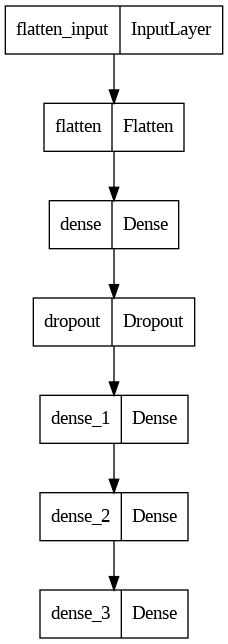

In [22]:
plot_model(mlp_model)

### Fit Model

In [23]:
history = mlp_model.fit(X, y, epochs=30,batch_size=64, validation_split=0.2)

Epoch 1/30
81/81 [==============================] - 1s 8ms/step - loss: 19.4935 - accuracy: 0.7070 - f1_m: 0.1060 - val_loss: 8.0010 - val_accuracy: 0.8002 - val_f1_m: 0.0000e+00
Epoch 2/30
81/81 [==============================] - 0s 4ms/step - loss: 1.7743 - accuracy: 0.7375 - f1_m: 0.0330 - val_loss: 4.5356 - val_accuracy: 0.7531 - val_f1_m: 0.0000e+00
Epoch 3/30
81/81 [==============================] - 0s 4ms/step - loss: 0.8939 - accuracy: 0.7708 - f1_m: 0.0243 - val_loss: 4.1564 - val_accuracy: 0.7160 - val_f1_m: 0.0000e+00
Epoch 4/30
81/81 [==============================] - 0s 4ms/step - loss: 0.6075 - accuracy: 0.8000 - f1_m: 0.0531 - val_loss: 5.0697 - val_accuracy: 0.7130 - val_f1_m: 0.0000e+00
Epoch 5/30
81/81 [==============================] - 0s 4ms/step - loss: 0.4823 - accuracy: 0.8142 - f1_m: 0.1289 - val_loss: 3.4259 - val_accuracy: 0.7431 - val_f1_m: 0.0000e+00
Epoch 6/30
81/81 [==============================] - 0s 4ms/step - loss: 0.4174 - accuracy: 0.8301 - f1_m: 0.0

# Inference

In [24]:
def inference(question):
  X_test = []
  tokenized_text, tok_tensor, seg_tensors = Preprocess_For_Bert(question, tokenizer)
  tok_embeds = Etract_Bert_Embeds(tok_tensor, seg_tensors, bert_model)
  q_embed = torch.stack(tok_embeds, dim=0).sum(dim=0)
  for probebel_ans in answer_embeds.items():
    x = torch.cat((q_embed, probebel_ans[1]), 0).numpy()
    X_test.append(x)
  
  X_test = np.array(X_test)
  #print(X_test)
  pred=mlp_model.predict(X_test)
  print(pred)
  max = pred[0][1]
  index=0
  for idx,p in enumerate(pred):
    if p[1] > max :
      max = p[1]
      index=idx
  return candidate_answers[index]

In [25]:
inference("چگونه می توان از موفقیت آمیز بودن خرید اینترنتی مطمئن گردید؟")

1/1 [==============================] - 0s 74ms/step
[[4.47700024e-01 5.30534267e-01]
 [4.47700024e-01 5.30534267e-01]
 [8.43454659e-01 1.52511045e-01]
 [8.93867314e-01 4.41270135e-02]
 [9.83991265e-01 6.97262436e-02]
 [8.45560431e-01 1.79751292e-01]
 [9.87580538e-01 7.23380074e-02]
 [8.44886720e-01 1.83427155e-01]
 [9.89008963e-01 1.50027219e-02]
 [9.99556839e-01 3.66649151e-01]
 [9.99991179e-01 1.36140059e-03]
 [9.99995589e-01 9.29299090e-03]
 [9.99648571e-01 9.33141410e-02]
 [6.96884453e-01 1.61133021e-01]
 [4.47700024e-01 5.30534267e-01]
 [9.99992847e-01 4.12462192e-04]
 [1.00000000e+00 3.82882814e-17]
 [1.00000000e+00 2.52938833e-07]
 [1.00000000e+00 1.20380055e-05]]


'پس \u200e\u200e\u200e\u200e\u200e\u200e\u200e\u200e\u200e\u200e\u200e\u200e\u200eاز انجام خرید سیم کارت از طریق فروشگاه آنلاین همراه اول، می توانید با شماره ای که با آن اقدام به خرید سیم کارت نموده اید وارد حساب کاربری خود شده و در بخش سفارشات من وضعیت خرید را بررسی نمایید.'

In [26]:
inference('قیمت سیم کارت عادی با پیش شماره 0912 چند است؟')

1/1 [==============================] - 0s 16ms/step
[[9.9635625e-01 1.4778720e-02]
 [9.9411494e-01 1.5029571e-02]
 [6.3938642e-01 1.0824471e-03]
 [5.5223668e-01 3.6456506e-04]
 [4.4770002e-01 5.3053427e-01]
 [5.5944711e-01 2.1208979e-02]
 [4.4770002e-01 5.3053427e-01]
 [5.6135201e-01 2.6392540e-02]
 [9.3215185e-01 2.4178276e-02]
 [4.3808648e-01 2.8636614e-02]
 [9.5402586e-01 7.7198811e-02]
 [9.8017061e-01 9.3649909e-02]
 [2.9338247e-01 3.7190872e-01]
 [9.9947184e-01 1.2384075e-03]
 [9.9521130e-01 8.0788787e-03]
 [9.7685653e-01 4.8427731e-02]
 [1.0000000e+00 7.6041969e-14]
 [9.9999952e-01 8.7683020e-06]
 [9.9999380e-01 4.9913785e-04]]


'قیمت سیم کارت دائمی همراه اول، طرح فیروزه ای درجه یک 1400-000 تومان، فیروزه ای درجه دو 800-000 تومان، فیروزه ای درجه سه 600-000 تومان، زمردی 166-800 تومان (با 40% تخفیف 100-000 تومان) و سیم کارت عادی (با پیش شماره 0910) 130-800 تومان می باشد.'